In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Load the Dataset

In [2]:
df = pd.read_csv('Titanic Dataset.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Exploration on the Dataset

In [3]:
# dimensions
df.shape

(891, 12)

In [4]:
# datatypes
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [5]:
# checking for the null values
100*df.isna().mean()

PassengerId     0.000000
Survived        0.000000
Pclass          0.000000
Name            0.000000
Sex             0.000000
Age            19.865320
SibSp           0.000000
Parch           0.000000
Ticket          0.000000
Fare            0.000000
Cabin          77.104377
Embarked        0.224467
dtype: float64

In [6]:
#checking the balance of the dataset
survival_count = df["Survived"].value_counts()
survival_rate = 100*survival_count/df.shape[0]
survival_data = pd.concat([survival_count, survival_rate], axis=1).reset_index()
survival_data.columns = ['Survived','Count','Percentage']

survival_data

,Survived,Count,Percentage
0,0,549,61.616162
1,1,342,38.383838


Text(0.5, 1.0, 'Percentage Survival of the Titanic Passengers')

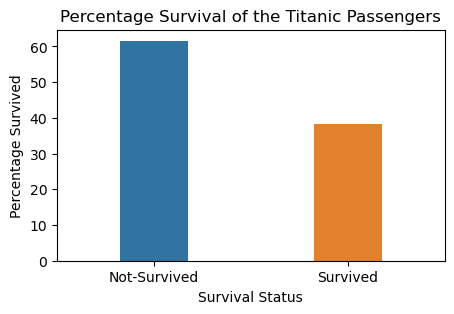

In [7]:
# plot the survival percentage
plt.figure(figsize=(5,3))
sns.barplot(survival_data, x=['Not-Survived','Survived'],y='Percentage',
            width=0.35)
plt.ylabel('Percentage Survived')
plt.xlabel('Survival Status')
plt.title('Percentage Survival of the Titanic Passengers')

In [8]:
# function to show survival rate according to grps
def survival_acc_to_grp(df, colname):
    plt.figure(figsize=(5,3))
    # Group by the 'Survived' and the specified column, then count the occurrences
    survival_by_pclass = df.groupby(['Survived', colname]).size().reset_index(name='count')
    sns.barplot(data=survival_by_pclass, x=colname, y='count', hue='Survived')
    plt.ylabel('Number of Survived')
    plt.title(f'Survival Count by {colname}')

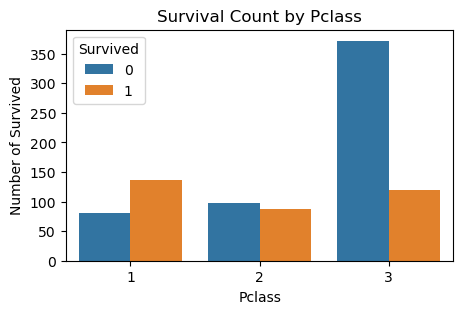

In [9]:
# survival among the Pclass
survival_acc_to_grp(df, 'Pclass')

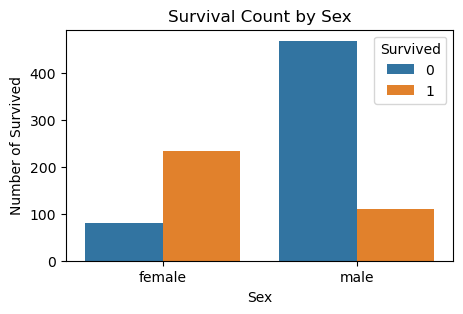

In [10]:
# survival among the sex
survival_acc_to_grp(df, 'Sex')

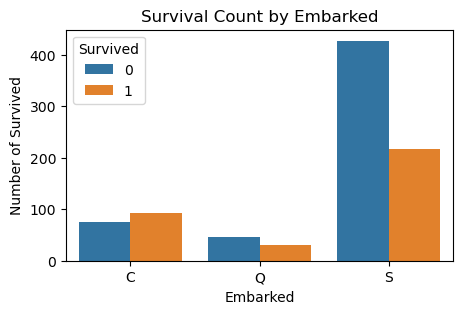

In [11]:
# survival among the Embarked
survival_acc_to_grp(df, 'Embarked')

In [12]:
# function to show distribution of variables according to survival
def vars_acc_to_surv(df, colname):
    plt.figure(figsize=(5,3))
    sns.kdeplot(df, x=colname, hue='Survived')
    plt.title(f'{colname} distribution according to the survival')

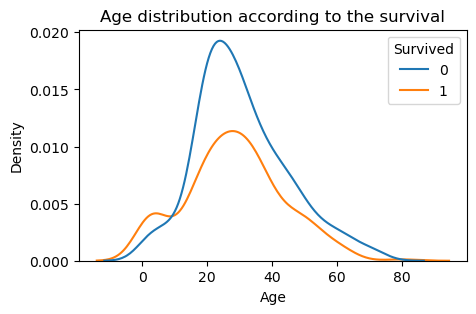

In [13]:
# age distribution according to survival status
vars_acc_to_surv(df, 'Age')

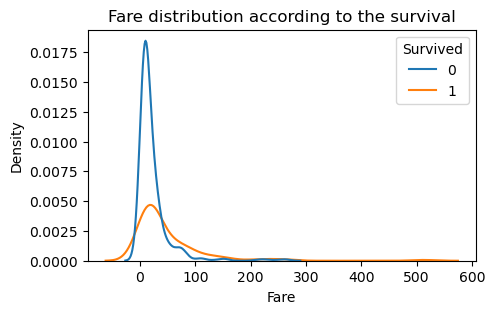

In [14]:
# fare distribution according to survival status
vars_acc_to_surv(df, 'Fare')

In [15]:
# function to visualize count data according to survival
def count_acc_to_surv(df, colname):
    plt.figure(figsize=(5,3))
    df1 = df.groupby(['SibSp','Survived']).count()['PassengerId'].reset_index()
    sns.barplot(df1, x='SibSp', y='PassengerId', hue='Survived')
    plt.title(f'{colname} according to survival')
    plt.xlabel(f'{colname}')
    plt.ylabel('count')

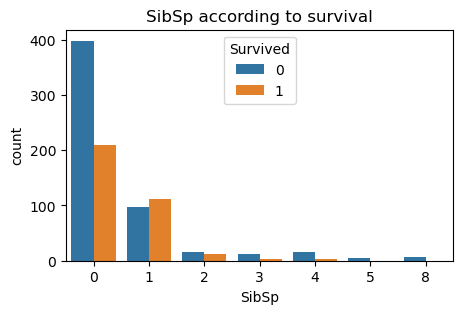

In [16]:
# SibSp distribution according to survival status
count_acc_to_surv(df, 'SibSp')

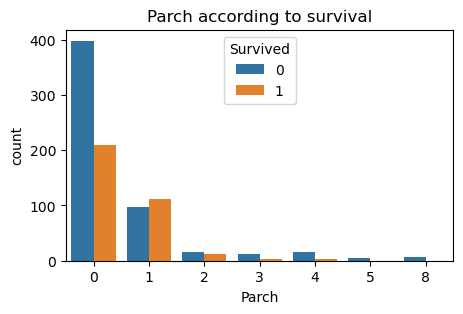

In [17]:
# Parch distribution according to survival status
count_acc_to_surv(df, 'Parch')

Text(0.5, 1.0, 'Comparison of the continuous variables')

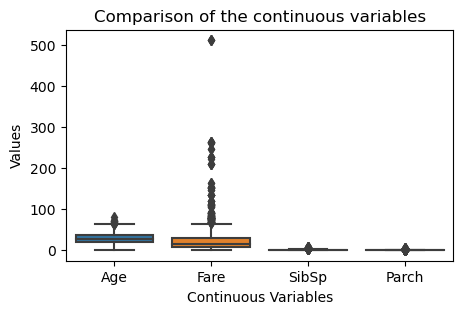

In [18]:
# variability and the location of the continuous variables
cont_vars = pd.melt(df, value_vars=['Age', 'Fare', 'SibSp', 'Parch'])
plt.figure(figsize=(5,3))
sns.boxplot(cont_vars, x='variable', y='value')
plt.xlabel('Continuous Variables')
plt.ylabel('Values')
plt.title('Comparison of the continuous variables')

# Data Preparation

In [19]:
# taking out the important features
df = df.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis=1)
df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [20]:
# deleting rows that has Null values in 'Fare' column
df = df.dropna(subset='Fare')

In [21]:
# filling up the missing values of the 'Age' column by the median age
df['Age'] = df['Age'].fillna(df['Age'].median())

In [22]:
df.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [23]:
# handling imbalance
# Create dataframes for survived and not survived
df_survived = df[df['Survived'] == 1]
df_not_survived = df[df['Survived'] == 0]

# Resample the survived dataframe to have the same number of rows as the not survived dataframe
df_survived_resampled = df_survived.sample(n=df_not_survived.shape[0], replace=True, random_state=101)

# Concatenate the not survived dataframe with the resampled survived dataframe
df_balanced = pd.concat([df_not_survived, df_survived_resampled]).sample(frac=1, random_state=26)

# Display the balanced dataframe
print(df_balanced)


     Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
849         1       1  female  28.0      1      0  89.1042        C
735         0       3    male  28.5      0      0  16.1000        S
857         1       1    male  51.0      0      0  26.5500        S
336         0       1    male  29.0      1      0  66.6000        S
272         1       2  female  41.0      0      1  19.5000        S
..        ...     ...     ...   ...    ...    ...      ...      ...
354         0       3    male  28.0      0      0   7.2250        C
21          1       2    male  34.0      0      0  13.0000        S
430         1       1    male  28.0      0      0  26.5500        S
244         0       3    male  30.0      0      0   7.2250        C
596         1       2  female  28.0      0      0  33.0000        S

[1098 rows x 8 columns]


In [24]:
df_balanced['Survived'].value_counts()

1    549
0    549
Name: Survived, dtype: int64

In [25]:
# splitting in to X and y
X = df_balanced.drop(['Survived'], axis=1)
y = df_balanced['Survived']

In [26]:
#train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1055)

print(f'''
X_train: {X_train.shape}
X_test: {X_test.shape}
y_train: {y_train.shape}
y_test: {y_test.shape}''')


X_train: (878, 7)
X_test: (220, 7)
y_train: (878,)
y_test: (220,)


# Model Building

In [27]:
# preparing the model pipeline that includes
cont_cols = ['Age', 'Fare']
disc_cols = ['Pclass']
cat_cols = ['Sex', 'Embarked']

# Define the transformers for continuous, discrete, and categorical features
continuous_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

discrete_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(drop='first'))
])


preprocessor = ColumnTransformer(
    transformers=[
        ('cont', continuous_transformer, cont_cols),
        ('disc', discrete_transformer, disc_cols),
        ('cat', categorical_transformer, cat_cols)
    ]
)

model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', LogisticRegression())])

# Assuming X_train and y_train are already defined
model.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('disc',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Pclass']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Embarked'])])),
                ('classifier', LogisticRegression())])

In [28]:
# prediction
y_pred = model.predict(X_test)
y_pred

array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0],
      dtype=int64)

In [29]:
# classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.71      0.85      0.77        93
           1       0.87      0.74      0.80       127

    accuracy                           0.79       220
   macro avg       0.79      0.79      0.79       220
weighted avg       0.80      0.79      0.79       220



Text(33.22222222222222, 0.5, 'Predicted Value')

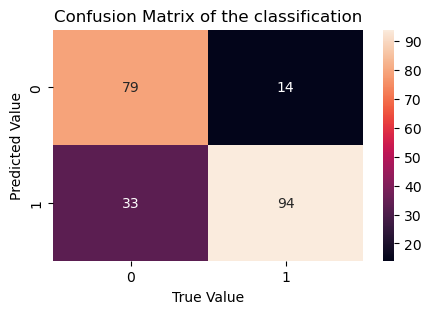

In [30]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,3))
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix of the classification')
plt.xlabel('True Value')
plt.ylabel('Predicted Value')

In [31]:
# saving the model
with open('.model_logistic.pkl', 'wb') as fp:
    pickle.dump(model,fp)

# Thank You